# NYC Taxi Fare Prediction - Full Project
This notebook builds and compares Linear Regression, XGBoost, and Neural Network models to predict NYC taxi fares.

In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers
%matplotlib inline

In [2]:
# Mount google drive from
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Copy the dataset to the current running environment
!cp /content/drive/MyDrive/nyc_taxi_fare_project/* ./

In [4]:
# Unzip the dataset
!unzip -q new-york-city-taxi-fare-prediction.zip

In [5]:
# 2. Load a subset of training data
print("Loading data...")
df = pd.read_csv("train.csv", nrows=2_000_000)

Loading data...


In [6]:
# 3. Data Cleaning
df = df.dropna()
df = df[(df.fare_amount >= 2.5) & (df.fare_amount < 200)]
df = df[(df.passenger_count >= 1) & (df.passenger_count <= 6)]

def in_nyc_bounds(lat, lon):
    return (lat >= 40.5) & (lat <= 41.8) & (lon >= -74.5) & (lon <= -72.8)

df = df[
    in_nyc_bounds(df.pickup_latitude, df.pickup_longitude) &
    in_nyc_bounds(df.dropoff_latitude, df.dropoff_longitude)
]

In [7]:
# 4. Feature Engineering
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2.0)**2
    return R * 2 * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
df['lat_diff'] = df['dropoff_latitude'] - df['pickup_latitude']
df['lon_diff'] = df['dropoff_longitude'] - df['pickup_longitude']

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True)
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year
df['is_weekend'] = df['day'].isin([5, 6]).astype(int)
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)

features = ['passenger_count', 'distance_km', 'lat_diff', 'lon_diff', 'hour', 'day', 'month', 'year', 'is_weekend', 'is_rush_hour']
X = df[features]
y = df['fare_amount']

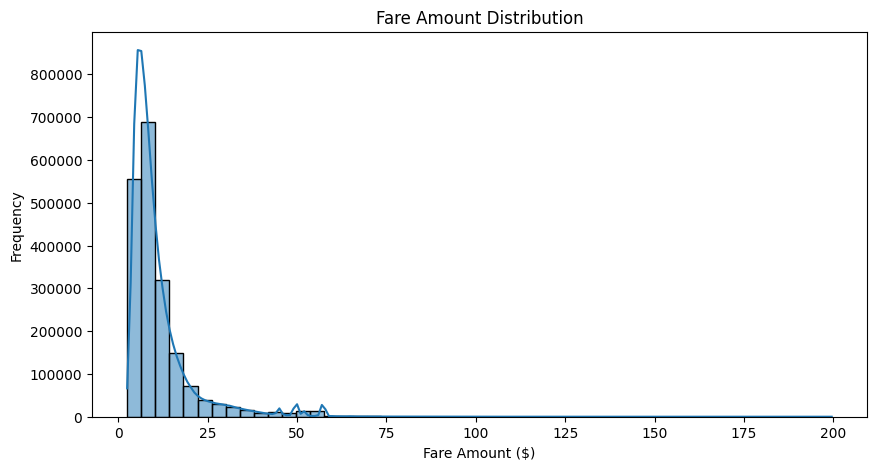

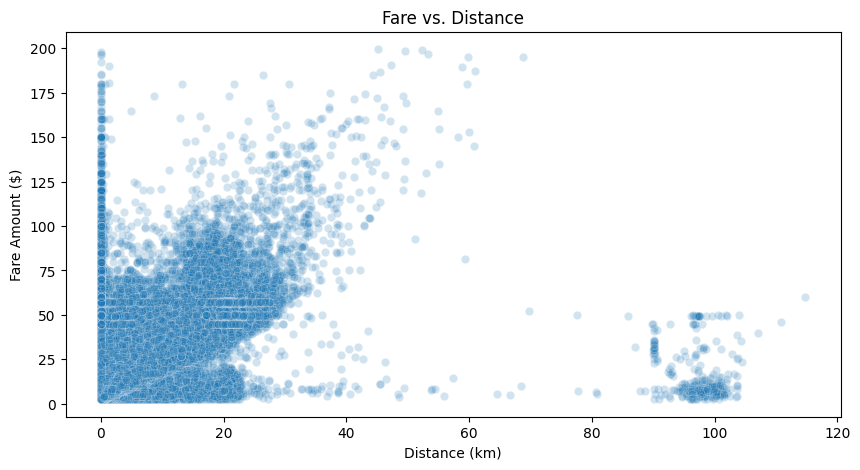

In [8]:
# Visualizations
plt.figure(figsize=(10, 5))
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Fare Amount Distribution')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x='distance_km', y='fare_amount', data=df, alpha=0.2)
plt.title('Fare vs. Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount ($)')
plt.show()

In [9]:
# 5. Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# 6. Linear Regression
print("Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
mae_lr = mean_absolute_error(y_val, y_pred_lr)
print(f"Linear Regression RMSE: {rmse_lr:.2f}, MAE: {mae_lr:.2f}")

Training Linear Regression...
Linear Regression RMSE: 5.56, MAE: 2.45


In [11]:
# 7. XGBoost Model
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
print(f"XGBoost RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}")

Training XGBoost...
XGBoost RMSE: 4.11, MAE: 1.81


In [12]:
# 8. Neural Network
print("Training Neural Network...")
model_nn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(features)]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model_nn.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_nn.fit(X_train, y_train, epochs=5, batch_size=512, validation_split=0.1, verbose=1)
y_pred_nn = model_nn.predict(X_val).flatten()
rmse_nn = np.sqrt(mean_squared_error(y_val, y_pred_nn))
mae_nn = mean_absolute_error(y_val, y_pred_nn)
print(f"Neural Net RMSE: {rmse_nn:.2f}, MAE: {mae_nn:.2f}")

Training Neural Network...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 555.2343 - mae: 8.5525 - val_loss: 31.7911 - val_mae: 3.4740
Epoch 2/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 28.3101 - mae: 2.7003 - val_loss: 30.2557 - val_mae: 2.8075
Epoch 3/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 27.5333 - mae: 2.9042 - val_loss: 24.6930 - val_mae: 2.4676
Epoch 4/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 26.7634 - mae: 2.8731 - val_loss: 24.1653 - val_mae: 2.4282
Epoch 5/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 25.9515 - mae: 2.7888 - val_loss: 23.9561 - val_mae: 2.5103
12193/12193 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
Neural Net RMSE: 4.92, MAE: 2.50



Model Comparison:
               Model      RMSE       MAE
0  Linear Regression  5.562248  2.449524
1            XGBoost  4.111378  1.814243
2     Neural Network  4.921373  2.503296


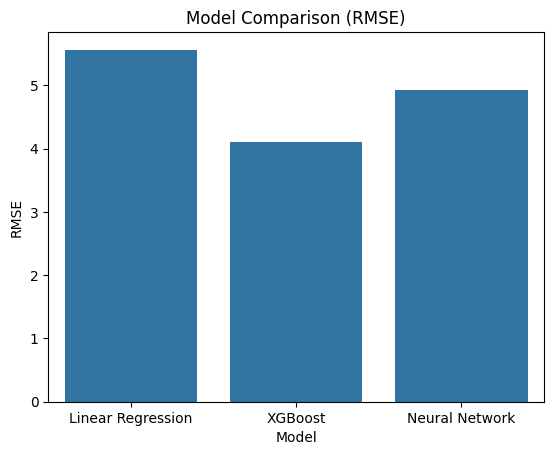

In [13]:
# 9. Compare Results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost', 'Neural Network'],
    'RMSE': [rmse_lr, rmse_xgb, rmse_nn],
    'MAE': [mae_lr, mae_xgb, mae_nn]
})

print("\nModel Comparison:")
print(results)

sns.barplot(x='Model', y='RMSE', data=results)
plt.title('Model Comparison (RMSE)')
plt.show()

In [14]:
# 10. Generate submission.csv using best model (XGBoost for example)
print("Generating submission file...")
test = pd.read_csv('test.csv')
test['distance_km'] = haversine(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'])
test['lat_diff'] = test['dropoff_latitude'] - test['pickup_latitude']
test['lon_diff'] = test['dropoff_longitude'] - test['pickup_longitude']
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], utc=True)
test['hour'] = test['pickup_datetime'].dt.hour
test['day'] = test['pickup_datetime'].dt.dayofweek
test['month'] = test['pickup_datetime'].dt.month
test['year'] = test['pickup_datetime'].dt.year
test['is_weekend'] = test['day'].isin([5, 6]).astype(int)
test['is_rush_hour'] = test['hour'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)
X_test = test[features]
test['fare_amount'] = xgb_model.predict(X_test)
test[['key', 'fare_amount']].to_csv('submission.csv', index=False)
print("submission.csv has been created.")

print("\nProject complete.")

Generating submission file...
submission.csv has been created.

Project complete.


In [15]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>